In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
from utils import audio, channels, synchronize, channel_estimate,ofdm, encode, decode, preamble,correction

cwd = os.getcwd()

In [3]:
#baisc parameter definition
filename = 'multiframe_1'            #rememeber to change everytime

chirp_duration = 1
record_duration = 50
fs = 48000

DFT_LENGTH = 4096
CP_LENGTH = 512
symbol_per_frame = 128
low_freq = 1000
high_freq = 10000

encode_method = 'qpsk'
double_chirp = False
known_ofdm = True

#define chirp used in the signal
chirp_range = [1000,10000]
chirp = preamble.generate_chirp(chirp_duration, fs, low=chirp_range[0], high=chirp_range[1], silence_duration=0, double=double_chirp)

#define known ofdm symbol
#seed_known = 7
known_ofdm = True
repeat_time = 4
# if known_ofdm:
#     known_ofdm_data = preamble.generate_known_ofdm(fs,DFT_LENGTH,CP_LENGTH,low_freq,high_freq,encode_method,repeat_time,seed_known)
# else:
#     known_ofdm_data = np.array([])
known_ofdm_data = preamble.load_known_ofdm(CP_LENGTH,repeat_time)
spb = ofdm.subcarriers_per_block(fs,DFT_LENGTH,low_freq,high_freq)

In [4]:
#record and save
#received_signal = audio.record(record_duration, fs)
#audio.signal_to_wav(received_signal,fs,filename,"audio_files")

In [5]:
#load recorded signals
received_signal,_ = np.array(audio.wav_to_signal(filename,'audio_files'))

C:\Users\17927\AppData\Local\Temp/ipykernel_15476/2826014932.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  received_signal,_ = np.array(audio.wav_to_signal(filename,'audio_files'))


In [6]:
#synchronize: convolve and find
start,convolved = synchronize.chirp_synchronize(received_signal,chirp_range, fs,duration=1)
event_end = np.array(synchronize.impulse_detect(abs(convolved),fs,duration = 1,window_time=0.3,threshold=2))

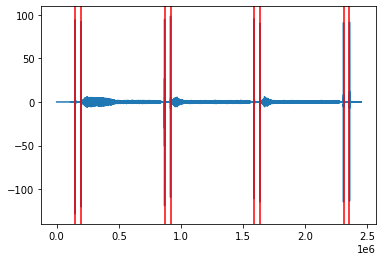

In [7]:
#plot the convolved result
plt.plot(convolved)
for pos in event_end:
    plt.axvline(x = pos, color = 'r')
plt.show()

In [8]:
# #check that the synchronization is correct
# a1 = np.argmax(abs(convolved[:record_duration*fs//2]))
# a2 = np.argmax(abs(convolved[record_duration*fs//2:])) + record_duration*fs//2

# print(event_end,"max of convoled data: ", a1,a2)

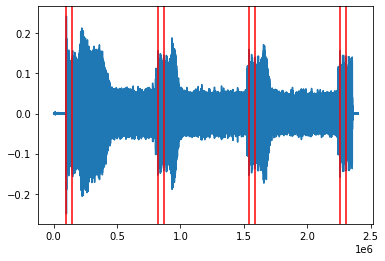

8 chirp events found at [ 100351  148352  819975  867975 1539599 1587599 2259222 2307223] , is that as expected? 


In [10]:
#plot found chirp in received signal
event_start = event_end - fs*chirp_duration
chirp_received = received_signal[event_start[0]:event_start[0]+chirp_duration*fs]   #taking only the first event for the time being

plt.plot(received_signal)
for pos in event_start:
    plt.axvline(x = pos, color = 'r')
plt.show()
#event = event_start
print(str(len(event_start))+" chirp events found at "+ str(event_start)+" , is that as expected? ")

In [19]:
events = np.array([ [event_start[2*i+1],event_start[2*i+2]] for i in range(len(event_start)//2-1) ])
sample_diffs = events[:,1]-events[:,0]-(symbol_per_frame*(DFT_LENGTH+CP_LENGTH)+chirp_duration*fs+known_ofdm_data.size*2)
frame_count = sample_diffs.size
print(str(frame_count)+" frames found, sample diff ",sample_diffs)

3 frames found, sample diff  [7 8 7]


In [25]:
#estimate with known ofdm
known_ofdm_start = (events[:,0] + fs*(chirp_duration)).astype(int) #need to change accordingly
known_ofdm_end = known_ofdm_start + known_ofdm_data.size

received_known = np.array([received_signal[known_ofdm_start[i]:known_ofdm_end[i]] for i in range(frame_count)]) #received ofdm part

#remove the first cyclic prefix manually then find discarded
received_known = received_known[:,CP_LENGTH:]

#estimate
H_known_ofdm = ofdm.known_ofdm_estimate_edited(received_known,known_ofdm_data[CP_LENGTH:CP_LENGTH+DFT_LENGTH],DFT_LENGTH,CP_LENGTH,low_freq,high_freq,fs)



In [28]:
#used for ofdm after a chirp only
ofdm_start = known_ofdm_end
ofdm_end = ofdm_start+symbol_per_frame*(DFT_LENGTH+CP_LENGTH)
received_ofdm = np.array([received_signal[ofdm_start[i]:ofdm_end[i]] for i in range(frame_count)])  #received ofdm information

#process received data
fft = ofdm.ofdm_to_fourier(received_ofdm, DFT_LENGTH, CP_LENGTH)
discarded = ofdm.subcarrier_extract(fft, DFT_LENGTH, fs, low_freq, high_freq)
deconvolved = ofdm.deconvolve(discarded, H_known_ofdm, DFT_LENGTH, fs, low_freq, high_freq,True)

(294912,)


In [11]:
# phase correction
sample_diff = 7
deconvolved = correction.phase_correction(deconvolved, sample_diff, DFT_LENGTH, fs, low_freq, high_freq)

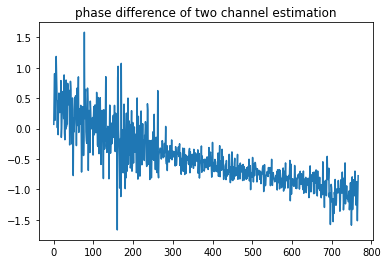

In [12]:
#plot the phase difference between the two channel estimation done with known ofdm symbols
phase_diff,H1,H2 = correction.phase_difference(received_signal, event,known_ofdm_data,CP_LENGTH,DFT_LENGTH,fs,low_freq,high_freq,repeat_time)

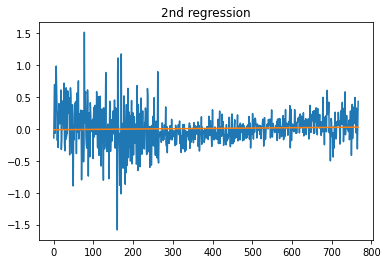

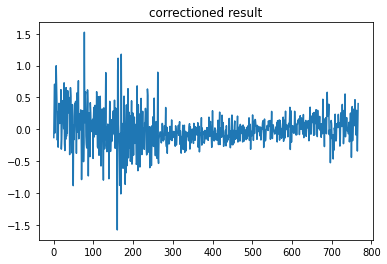

-0.00179532177248911 0.19989280100323545


In [13]:
#find regression of the phase diff plot by looking at a selected linear range
#iterate until satisfied with range for regression

from IPython.display import clear_output
reply = "n"
while reply != "y":
    regression_range_1 = np.array(input("range to perform regression: ").split()).astype(int)
    clear_output()
    start1,end1 = regression_range_1
    if end1 > phase_diff.size:
        end1 = phase_diff.size
    plt.plot(phase_diff[start1:end1])
    section1 = phase_diff[start1:end1]
    x_1 = np.linspace(0,end1,num=(end1-start1))
    slope1, intercept1, r_value, p_value, std_err = scipy.stats.linregress(x_1, section1)
    plt.plot(x_1*slope1+intercept1)
    print(slope1,intercept1)
    plt.title("1st regression")
    plt.show()
    reply = input("confirm range? y/n")

clear_output()
deconvolved = correction.regression_correction(spb,slope1,intercept1,H1,H2,deconvolved,symbol_per_frame)



In [14]:
#check accuracy
new = True
if new:
    np.random.seed(8)
    encoded = np.random.randint(2, size=2*128*spb)
    np.savetxt('encoded', encoded, fmt='%i')


In [ ]:
phase_plot_range = 3000
plt.scatter(np.real(deconvolved[:phase_plot_range]),np.imag(deconvolved[:phase_plot_range])) #plot the received phase distribution
print(deconvolved.size)

In [ ]:
if encode_method == 'qpsk':
    decoded = decode.qpsk_decode(deconvolved)
elif encode_method == 'bpsk':
    decoded = decode.bpsk_decode(deconvolved)
print(encoded.size, decoded.size)
print("source:\n", encoded[:30])
print("decoded:\n", decoded[:30])

In [ ]:
equality = encoded == decoded[:encoded.size]
equality = equality[:]
print("correct rate:\n", np.sum(equality.astype(int))/equality.size)

In [17]:
#for multiframes
if new:
    np.random.seed(8)
    encoded_3 = np.random.randint(2, size=2*128*spb*3)
    np.savetxt('encoded', encoded_3, fmt='%i')

encoded_3 = np.reshape(encoded_3,(-1,2*spb*128))
encoded = encoded_3[2,:]

decoded = decode.qpsk_decode(deconvolved)
equality = encoded == decoded[:encoded.size]
#equality = equality[:]
print("correct rate:\n", np.sum(equality.astype(int))/equality.size)

correct rate:
 0.9843648274739584


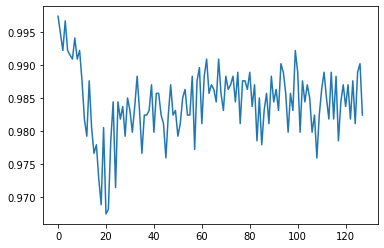

In [18]:
#error of each symbol
e_symbol = [0]*symbol_per_frame
for n in range(symbol_per_frame):
    n=int(n)
    a = equality[2*spb*n:2*spb*(n+1)]
    e_symbol[n] = np.round(np.sum(a.astype(int))/a.size,4)
plt.plot(e_symbol)